In [124]:
# installing the required libraries
import pandas as pd
import scipy.sparse
# from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, \
                                      DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier, \
                                      LinearSVC, OneVsRest
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, SparseVector, _convert_to_vector, VectorUDT
from pyspark.sql.types import ArrayType, FloatType, IntegerType, DoubleType
from pyspark.sql.functions import udf, col, length, size, when
from pyspark.ml.feature import VectorAssembler, VectorSizeHint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

## Create spark session

In [2]:
spark = SparkSession.builder\
            .appName('eecs-e6893-project')\
            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Load dataset

In [3]:
# allows to view the entire columns
pd.set_option('display.max_columns', None)

# bucket name and data file location
BUCKET_NAME = "eecs-e6893-project-42"
DATA_FILE = f"gs://{BUCKET_NAME}/dataset/clean_data_80k.csv/part-00000-f67b3b6a-7626-4684-9336-4f101fce98f1-c000.csv"

In [98]:
# dataset = spark.read.csv(DATA_FILE, header=True, inferSchema=True, multiLine=True, escape="\\")
dataset = spark.read.csv(DATA_FILE, header=True, inferSchema=True, multiLine=True, escape=",", 
                    quote="\"")

### Converting to appropriate data types

In [99]:
dataset = dataset.withColumn("Score", dataset["Score"].cast(IntegerType()))
dataset = dataset.withColumn("ViewCount", dataset["ViewCount"].cast(IntegerType()))
dataset = dataset.withColumn("AnswerCount", dataset["AnswerCount"].cast(IntegerType()))
dataset = dataset.withColumn("CommentCount", dataset["CommentCount"].cast(IntegerType()))
dataset = dataset.withColumn("FavoriteCount", dataset["FavoriteCount"].cast(IntegerType()))
dataset = dataset.withColumn("Reputation", dataset["Reputation"].cast(IntegerType()))
dataset = dataset.withColumn("Views", dataset["Views"].cast(IntegerType()))
dataset = dataset.withColumn("UpVotes", dataset["UpVotes"].cast(IntegerType()))
dataset = dataset.withColumn("DownVotes", dataset["DownVotes"].cast(IntegerType()))
dataset = dataset.withColumn("Quality", dataset["Quality"].cast(IntegerType()))
dataset = dataset.withColumn("ATE", dataset["ATE"].cast(FloatType()))
dataset = dataset.withColumn("ARI", dataset["ARI"].cast(FloatType()))
dataset = dataset.withColumn("CLI", dataset["CLI"].cast(FloatType()))
dataset = dataset.withColumn("FKGL", dataset["FKGL"].cast(FloatType()))
dataset = dataset.withColumn("FKES", dataset["FKES"].cast(FloatType()))
dataset = dataset.withColumn("GFI", dataset["GFI"].cast(FloatType()))
dataset = dataset.withColumn("ME", dataset["ME"].cast(FloatType()))
dataset = dataset.withColumn("SI", dataset["SI"].cast(FloatType()))
dataset = dataset.withColumn("Sentences Count", dataset["Sentences Count"].cast(IntegerType()))
dataset = dataset.withColumn("Word Count", dataset["Word Count"].cast(IntegerType()))
dataset = dataset.withColumn("Tag Count", dataset["Tag Count"].cast(IntegerType()))
dataset = dataset.withColumn("Title & Text Similarity", dataset["Title & Text Similarity"].cast(FloatType()))


# take only quality with 0 and 1 values; discard others
dataset_lq = dataset.where(col('Quality') == 0)
dataset_hq = dataset.where(col('Quality') == 1)
dataset = dataset_lq.union(dataset_hq)

In [92]:
pd.DataFrame(dataset.take(50), columns=dataset.columns)

,_c0,Id,AcceptedAnswerId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Reputation,Views,UpVotes,DownVotes,Quality,Text,CodeBody,CleanBody,ATE,ARI,CLI,FKGL,FKES,GFI,ME,SI,LOC,Sentences Count,Word Count,Tag Count,Title & Text Similarity
0,0,8019330,8019355.0,-1,246,<p>My lines:</p>\n\n<pre><code>ABC: XYZ\nXYZ A...,935420,"In Perl, how can I join an input line with the...",<perl>,6,4,0,103,31,0,0,0,my lines:\nabc: xyz\nxyz abc: xyz\nxyz:\nabc\n...,ABC: XYZ\nXYZ ABC: XYZ\nXYZ:\nABC\nXYZ\nABC:\n...,My lines:\n\n\n\nI want to join lines end with...,3.418296,0.000000,13.600000,0.000000,0.000000,0.000000,0.050269,0.0000,0.585366,0.0,0.0,1.0,0.412514
1,28,6347039,6347078.0,9,17203,"<p>I'm developing a web application, using ASP...",586528,How to process payments through cards?,<c#><asp.net><e-commerce><payment-gateway><cre...,6,0,6,17348,418,165,2,0,"i'm developing a web application, using asp.ne...",None,"I'm developing a web application, using ASP.ne...",5.777211,39.135597,200.871994,31.289133,70.222672,45.299999,0.012725,3.1291,0.000000,4.0,453.0,5.0,0.249682
2,32,21157069,None,16,62548,<p>Hi it is my first time that I publish a pro...,2915302,Unable to find the requested .Net Framework Da...,<c#><asp.net><.net><entity-framework>,10,1,6,295,70,144,0,0,hi it is my first time that i publish a projec...,None,Hi it is my first time that I publish a projec...,6.543900,-2.319059,446.013336,-1.178543,154.316132,11.908695,0.002388,3.1291,0.000000,92.0,2739.0,4.0,0.454179
3,51,1764898,1764924.0,13,28167,<p>I am maintaining some code which looks some...,8852,How do I safely stop a C# .NET thread running ...,<c#><.net><windows-services>,8,2,2,1381,243,81,11,0,i am maintaining some code which looks somethi...,namespace WorkService\n{\n public partial c...,I am maintaining some code which looks somethi...,5.795939,23.002573,215.572006,18.686827,103.431122,32.466667,0.011828,3.1291,0.605792,6.0,487.0,3.0,0.329864
4,52,4930497,None,0,354,<p>I've been crawling a lot of websites for co...,81785,What are the best measures to protect content ...,<html><security><web-scraping><web-crawler>,6,1,0,11303,1517,2462,165,0,i've been crawling a lot of websites for conte...,&lt;nofollow&gt;,I've been crawling a lot of websites for conte...,6.159658,21.308140,140.897995,17.449091,105.106445,30.850000,0.009263,3.1291,0.023495,8.0,617.0,4.0,0.356575
5,53,194574,194637.0,6,33567,<p>I was trying to insert new data into an exi...,27090,Inserting data in XML file with PHP DOM,<php><xml><dom>,6,0,2,3769,442,744,6,0,i was trying to insert new data into an existi...,&lt;list&gt;\n &lt;activity&gt;swimming&lt;...,I was trying to insert new data into an existi...,6.460240,23.754255,152.164001,19.368605,101.260445,33.076923,0.006004,3.1291,0.524104,13.0,1075.0,3.0,0.182574
6,105,14828,None,3,517,"<p>I work on quite a few DotNetNuke sites, and...",1795,Issues with DB after publishing via Database P...,<sql><deployment><dotnetnuke>,7,0,0,1019,146,44,6,0,"i work on quite a few dotnetnuke sites, and oc...",None,"I work on quite a few DotNetNuke sites, and oc...",6.422011,18.732313,175.584000,15.512777,110.832191,29.018183,0.008038,3.1291,0.000000,11.0,798.0,3.0,0.167944
7,116,11917527,None,17,16908,<p>I've been reading a few REST tutorials and ...,748789,Should Rest API accept POST array or JSON string?,<php><json><api><rest>,7,2,5,11207,675,934,2,0,i've been reading a few rest tutorials and som...,$data = array('foo' =&gt; 'bar');\n$rest-&gt;p...,I've been reading a few REST tutorials and som...,6.094482,55.457363,122.377998,44.050617,37.060410,58.400002,0.010418,3.1291,0.195323,4.0,584.0,4.0,0.230022
8,148,10429322,10430827.0,11,50015,<p>In my ASP.NET project. I have two dropdownl...,998405,Dropdown list selected value not working,<c#><asp.net><drop-down-menu><selectedvalue>,7,3,1,1309,314,34,3,0,in my asp.net project. i have two dropdownlist...,DropDownList1DropDownList2DropDownList1.Select...,In my ASP.NET project. I have two dropdownli

In [94]:
dataset.show()

+---+--------+----------------+-----+---------+--------------------+-----------+--------------------+--------------------+-----------+------------+-------------+----------+-----+-------+---------+-------+--------------------+--------------------+--------------------+---------+----------+---------+----------+----------+---------+------------+------+-----------+---------------+----------+---------+-----------------------+
|_c0|      Id|AcceptedAnswerId|Score|ViewCount|                Body|OwnerUserId|               Title|                Tags|AnswerCount|CommentCount|FavoriteCount|Reputation|Views|UpVotes|DownVotes|Quality|                Text|            CodeBody|           CleanBody|      ATE|       ARI|      CLI|      FKGL|      FKES|      GFI|          ME|    SI|        LOC|Sentences Count|Word Count|Tag Count|Title & Text Similarity|
+---+--------+----------------+-----+---------+--------------------+-----------+--------------------+--------------------+-----------+------------+-----

In [93]:
print(dataset.count(), dataset.columns)

29685 ['_c0', 'Id', 'AcceptedAnswerId', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'Reputation', 'Views', 'UpVotes', 'DownVotes', 'Quality', 'Text', 'CodeBody', 'CleanBody', 'ATE', 'ARI', 'CLI', 'FKGL', 'FKES', 'GFI', 'ME', 'SI', 'LOC', 'Sentences Count', 'Word Count', 'Tag Count', 'Title & Text Similarity']


In [100]:
print("Features Dataset size: ", dataset.count())
print("Features Dataset size with quality 0: ", dataset.select('*').where(dataset['Quality'] == 0).count())
print("Features Dataset size with quality 1: ", dataset.select('*').where(dataset['Quality'] == 1).count())


[Stage 655:>                                                        (0 + 2) / 2]



Features Dataset size:  29685
Features Dataset size with quality 0:  6741
Features Dataset size with quality 1:  22944


In [23]:
dataset.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- AcceptedAnswerId: string (nullable = true)
 |-- Score: integer (nullable = true)
 |-- ViewCount: integer (nullable = true)
 |-- Body: string (nullable = true)
 |-- OwnerUserId: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- AnswerCount: integer (nullable = true)
 |-- CommentCount: integer (nullable = true)
 |-- FavoriteCount: integer (nullable = true)
 |-- Reputation: integer (nullable = true)
 |-- Views: integer (nullable = true)
 |-- UpVotes: integer (nullable = true)
 |-- DownVotes: integer (nullable = true)
 |-- Quality: integer (nullable = true)
 |-- Text: string (nullable = true)
 |-- CodeBody: string (nullable = true)
 |-- CleanBody: string (nullable = true)
 |-- ATE: float (nullable = true)
 |-- ARI: float (nullable = true)
 |-- CLI: float (nullable = true)
 |-- FKGL: float (nullable = true)
 |-- FKES: float (nullable = true)
 |-- GFI: float (nu

### Summary of the data

In [8]:
summary = dataset.describe('*')
pd.DataFrame(summary.take(50), columns=summary.columns)

,summary,_c0,Id,AcceptedAnswerId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Reputation,Views,UpVotes,DownVotes,Quality,Text,CodeBody,CleanBody,ATE,ARI,CLI,FKGL,FKES,GFI,ME,SI,LOC,Sentences Count,Word Count,Tag Count,Title & Text Similarity
0,count,33902,30824,1387,30385,30341,30329,30316,2202,2198,30301,30301,30301,30300,30298,30297,30286,29715,29660,19927,28509,29012,28995,28984,28964,28878,28891,28981,28980,28979,28979,28979,28950,28929
1,mean,24700.604475345102,2.7702933779303353E7,1.089503696368155E7,3.3385256826573095,1051.6448860668836,94.26842597593422,2432076.001538204,67.90634132995088,32.90257895160683,0.2919264961133799,1.2669570299242534,0.3399921071476191,75589.76543078771,18115.88857481497,2077.311897789248,1477.1573557660029,0.9405762570284371,94.67766352051515,1.8035899514000247E9,16.022212774555552,4.751128577782631,304.59115689212217,2018.9341434496869,7878.133726608315,78.30221682418495,28.619217347638823,0.07562524894060806,24.77247052110772,24.017899725070887,280.27069963084597,312.19745177153663,8.390194708017962,6.686197633095136
2,stddev,18045.012617385728,2.068728733564678E7,1.4823518417621741E7,19.84575185492687,16194.35408883234,82.76631745563779,3207617.839436025,63.55840744436789,35.427322357512274,3.8337211303586614,3.0778557475631443,6.575778179812776,190920.14866316508,106912.6115403957,4677.503993838517,7234.175739779575,13.266562119264204,376.72248940969536,1.3496827630970263E10,39.98938832303334,16.760923570699955,26518.072050274306,117183.58708271944,229775.4967548931,57.732103217679956,22.050367859560392,1.7663483908103625,2981.1032241230387,1990.0680548898383,12019.855547308136,2488.4816098824303,360.2907984780241,524.8097082843263
3,min,,,,%dest. so in intel syntax,,',2,,' elements'),2,4,-13.448,5,6,0,6,0.0,2,"\""\""zero\""\"" data is preserved in importing....",'turkey'],7,8,9,4,1.8.0_191 vs 14.0.1:,the cookies,etc. to check all of these factors i've found...,you could call type before asking for input:,0.0,0.0,0.0,0.0,0
4,max,╠════════════════╬════════════════════════════...,╔════════════════╦════════════════════════════...,{'var1':booktest}),you can use \n\nthen,true );,vsdbcmd.exe is a command line utility which ca...,"close , clear all;\nP=0;\nQ=0;\nI2=imread('132...",written code between <script> does not show up...,Use :,"movl var_a(%rip), %eax\nmovl var_10(%rip), %ed...","This will set to 1 if is less than , i.e. if...",733.0,9998,listdf = pd.DataFrame(data['fields.geolocation...,999,997,1726.0,•what is the dimension of the memory area poin...,☼sedecho $myString | sed 's/☼/ /g',•what is the dimension of the memory area poin...,you are defining the API implicit parameters t...,"With GNU awk for the 3rd arg to match(), gensu...",UAC is designed to present a confirmation prom...,Why did oracle scheduler job execute old pl/sq...,Want to login to remote server and then run fo...,<shell><loops>,9.5868885E-4,9350,287185.0,1044523.0,351806.0,38625.0,"you have a few options:\n\nin iis or apache, c..."


## Create features

In [159]:
features = ['Score', 'ViewCount', 'FavoriteCount', 'Reputation', 'Views', \
            'UpVotes', 'DownVotes', 'ATE', 'ARI', 'FKGL', 'FKES', 'GFI', 'SI', 'LOC', 'Sentences Count', \
            'Word Count', 'Tag Count', 'Title & Text Similarity']

model_assembler = VectorAssembler(inputCols=features, outputCol='features', handleInvalid='skip')
features_dataset = model_assembler.transform(dataset)

In [140]:
pd.DataFrame(features_dataset.take(50), columns=features_dataset.columns)

,_c0,Id,AcceptedAnswerId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Reputation,Views,UpVotes,DownVotes,Quality,Text,CodeBody,CleanBody,ATE,ARI,CLI,FKGL,FKES,GFI,ME,SI,LOC,Sentences Count,Word Count,Tag Count,Title & Text Similarity,features
0,0,8019330,8019355.0,-1,246,<p>My lines:</p>\n\n<pre><code>ABC: XYZ\nXYZ A...,935420,"In Perl, how can I join an input line with the...",<perl>,6,4,0,103,31,0,0,0,my lines:\nabc: xyz\nxyz abc: xyz\nxyz:\nabc\n...,ABC: XYZ\nXYZ ABC: XYZ\nXYZ:\nABC\nXYZ\nABC:\n...,My lines:\n\n\n\nI want to join lines end with...,3.418296,0.000000,13.600000,0.000000,0.000000,0.000000,0.050269,0.0000,0.585366,0,0,1,0.412514,"(-1.0, 246.0, 0.0, 103.0, 31.0, 0.0, 0.0, 3.41..."
1,28,6347039,6347078.0,9,17203,"<p>I'm developing a web application, using ASP...",586528,How to process payments through cards?,<c#><asp.net><e-commerce><payment-gateway><cre...,6,0,6,17348,418,165,2,0,"i'm developing a web application, using asp.ne...",None,"I'm developing a web application, using ASP.ne...",5.777211,39.135597,200.871994,31.289133,70.222672,45.299999,0.012725,3.1291,0.000000,4,453,5,0.249682,"[9.0, 17203.0, 6.0, 17348.0, 418.0, 165.0, 2.0..."
2,32,21157069,None,16,62548,<p>Hi it is my first time that I publish a pro...,2915302,Unable to find the requested .Net Framework Da...,<c#><asp.net><.net><entity-framework>,10,1,6,295,70,144,0,0,hi it is my first time that i publish a projec...,None,Hi it is my first time that I publish a projec...,6.543900,-2.319059,446.013336,-1.178543,154.316132,11.908695,0.002388,3.1291,0.000000,92,2739,4,0.454179,"[16.0, 62548.0, 6.0, 295.0, 70.0, 144.0, 0.0, ..."
3,51,1764898,1764924.0,13,28167,<p>I am maintaining some code which looks some...,8852,How do I safely stop a C# .NET thread running ...,<c#><.net><windows-services>,8,2,2,1381,243,81,11,0,i am maintaining some code which looks somethi...,namespace WorkService\n{\n public partial c...,I am maintaining some code which looks somethi...,5.795939,23.002573,215.572006,18.686827,103.431122,32.466667,0.011828,3.1291,0.605792,6,487,3,0.329864,"[13.0, 28167.0, 2.0, 1381.0, 243.0, 81.0, 11.0..."
4,52,4930497,None,0,354,<p>I've been crawling a lot of websites for co...,81785,What are the best measures to protect content ...,<html><security><web-scraping><web-crawler>,6,1,0,11303,1517,2462,165,0,i've been crawling a lot of websites for conte...,&lt;nofollow&gt;,I've been crawling a lot of websites for conte...,6.159658,21.308140,140.897995,17.449091,105.106445,30.850000,0.009263,3.1291,0.023495,8,617,4,0.356575,"[0.0, 354.0, 0.0, 11303.0, 1517.0, 2462.0, 165..."
5,53,194574,194637.0,6,33567,<p>I was trying to insert new data into an exi...,27090,Inserting data in XML file with PHP DOM,<php><xml><dom>,6,0,2,3769,442,744,6,0,i was trying to insert new data into an existi...,&lt;list&gt;\n &lt;activity&gt;swimming&lt;...,I was trying to insert new data into an existi...,6.460240,23.754255,152.164001,19.368605,101.260445,33.076923,0.006004,3.1291,0.524104,13,1075,3,0.182574,"[6.0, 33567.0, 2.0, 3769.0, 442.0, 744.0, 6.0,..."
6,105,14828,None,3,517,"<p>I work on quite a few DotNetNuke sites, and...",1795,Issues with DB after publishing via Database P...,<sql><deployment><dotnetnuke>,7,0,0,1019,146,44,6,0,"i work on quite a few dotnetnuke sites, and oc...",None,"I work on quite a few DotNetNuke sites, and oc...",6.422011,18.732313,175.584000,15.512777,110.832191,29.018183,0.008038,3.1291,0.000000,11,798,3,0.167944,"[3.0, 517.0, 0.0, 1019.0, 146.0, 44.0, 6.0, 6...."
7,116,11917527,None,17,16908,<p>I've been reading a few REST tutorials and ...,748789,Should Rest API accept POST array or JSON string?,<php><json><api><rest>,7,2,5,11207,675,934,2,0,i've been reading a few rest tutorials and som...,$data = array('foo' =&gt; 'bar');\n$rest-&gt;p...,I've been reading a few REST tutorials and som...,6.094482,55.457363,122.377998,44.050617,37.060410,58.400002,0.010418,3.1291,0.195323,4,584,4,0.230022,"[17.0, 16908.0, 5.

### Converting Dense vectors to Sparse

In [28]:
@udf(returnType=VectorUDT())
def convert_dense_to_sparse(feature):
    return _convert_to_vector(scipy.sparse.csc_matrix(feature.toArray()).T)

features_dataset = features_dataset.withColumn('features', convert_dense_to_sparse(features_dataset['features']))

In [141]:
print(features_dataset.count(), features_dataset.columns)

28851 ['_c0', 'Id', 'AcceptedAnswerId', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'Reputation', 'Views', 'UpVotes', 'DownVotes', 'Quality', 'Text', 'CodeBody', 'CleanBody', 'ATE', 'ARI', 'CLI', 'FKGL', 'FKES', 'GFI', 'ME', 'SI', 'LOC', 'Sentences Count', 'Word Count', 'Tag Count', 'Title & Text Similarity', 'features']


In [39]:
# vector size hint for removing features with inappropriate size
sizeHint = VectorSizeHint(
    inputCol="features",
    handleInvalid="skip",
    size=18)

features_dataset = sizeHint.transform(features_dataset)

### Calculating weight ratio amongst the two classes

In [160]:
# Weight of classes -- due to severe imbalance

num_low_quality = features_dataset.filter(features_dataset["Quality"] == 0).count()
dataset_size = features_dataset.count()
balancing_ratio = (dataset_size - num_low_quality)/float(dataset_size)
print(balancing_ratio)


@udf(returnType=FloatType())
def calculate_weights(label):
    if label == 0:
        return 1 * balancing_ratio
    return 1 * (1.0 - balancing_ratio)


features_dataset = features_dataset.withColumn('class_weight', calculate_weights(col('Quality')))    


[Stage 2418:============================>                           (1 + 1) / 2]



0.7769549042105629


### Visualization of the correlations amongst features

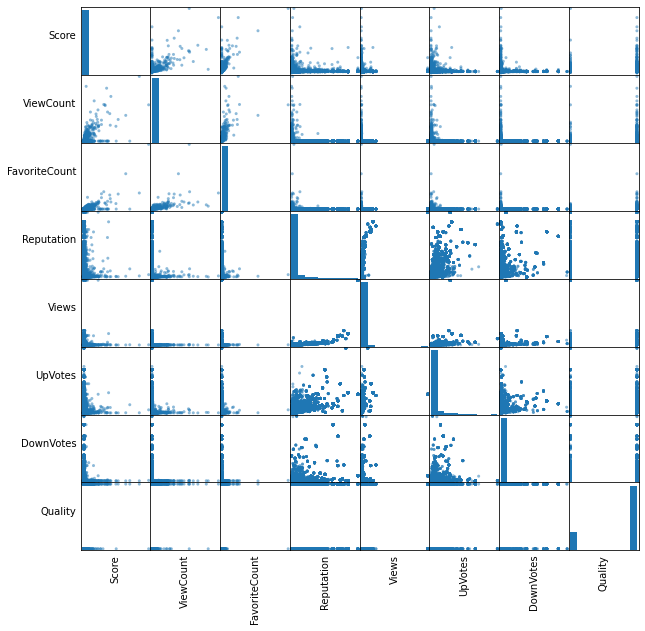

In [190]:
features_1 = ['Score', 'ViewCount', 'FavoriteCount', 'Reputation', 'Views', \
            'UpVotes', 'DownVotes', 'Quality']
numeric_data = features_dataset.select(features_1).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10, 10));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [80]:
pd.DataFrame(features_dataset.take(50), columns=features_dataset.columns)

,_c0,Id,AcceptedAnswerId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Reputation,Views,UpVotes,DownVotes,Quality,Text,CodeBody,CleanBody,ATE,ARI,CLI,FKGL,FKES,GFI,ME,SI,LOC,Sentences Count,Word Count,Tag Count,Title & Text Similarity,features,class_weight
0,0,8019330,8019355.0,-1,246,<p>My lines:</p>\n\n<pre><code>ABC: XYZ\nXYZ A...,935420,"In Perl, how can I join an input line with the...",<perl>,6,4,0,103,31,0,0,0,my lines:\nabc: xyz\nxyz abc: xyz\nxyz:\nabc\n...,ABC: XYZ\nXYZ ABC: XYZ\nXYZ:\nABC\nXYZ\nABC:\n...,My lines:\n\n\n\nI want to join lines end with...,3.418296,0.000000,13.600000,0.000000,0.000000,0.000000,0.050269,0.0000,0.585366,0,0,1,0.412514,"(-1.0, 246.0, 0.0, 103.0, 31.0, 0.0, 0.0, 3.41...",0.776955
1,28,6347039,6347078.0,9,17203,"<p>I'm developing a web application, using ASP...",586528,How to process payments through cards?,<c#><asp.net><e-commerce><payment-gateway><cre...,6,0,6,17348,418,165,2,0,"i'm developing a web application, using asp.ne...",None,"I'm developing a web application, using ASP.ne...",5.777211,39.135597,200.871994,31.289133,70.222672,45.299999,0.012725,3.1291,0.000000,4,453,5,0.249682,"[9.0, 17203.0, 6.0, 17348.0, 418.0, 165.0, 2.0...",0.776955
2,32,21157069,None,16,62548,<p>Hi it is my first time that I publish a pro...,2915302,Unable to find the requested .Net Framework Da...,<c#><asp.net><.net><entity-framework>,10,1,6,295,70,144,0,0,hi it is my first time that i publish a projec...,None,Hi it is my first time that I publish a projec...,6.543900,-2.319059,446.013336,-1.178543,154.316132,11.908695,0.002388,3.1291,0.000000,92,2739,4,0.454179,"[16.0, 62548.0, 6.0, 295.0, 70.0, 144.0, 0.0, ...",0.776955
3,51,1764898,1764924.0,13,28167,<p>I am maintaining some code which looks some...,8852,How do I safely stop a C# .NET thread running ...,<c#><.net><windows-services>,8,2,2,1381,243,81,11,0,i am maintaining some code which looks somethi...,namespace WorkService\n{\n public partial c...,I am maintaining some code which looks somethi...,5.795939,23.002573,215.572006,18.686827,103.431122,32.466667,0.011828,3.1291,0.605792,6,487,3,0.329864,"[13.0, 28167.0, 2.0, 1381.0, 243.0, 81.0, 11.0...",0.776955
4,52,4930497,None,0,354,<p>I've been crawling a lot of websites for co...,81785,What are the best measures to protect content ...,<html><security><web-scraping><web-crawler>,6,1,0,11303,1517,2462,165,0,i've been crawling a lot of websites for conte...,&lt;nofollow&gt;,I've been crawling a lot of websites for conte...,6.159658,21.308140,140.897995,17.449091,105.106445,30.850000,0.009263,3.1291,0.023495,8,617,4,0.356575,"[0.0, 354.0, 0.0, 11303.0, 1517.0, 2462.0, 165...",0.776955
5,53,194574,194637.0,6,33567,<p>I was trying to insert new data into an exi...,27090,Inserting data in XML file with PHP DOM,<php><xml><dom>,6,0,2,3769,442,744,6,0,i was trying to insert new data into an existi...,&lt;list&gt;\n &lt;activity&gt;swimming&lt;...,I was trying to insert new data into an existi...,6.460240,23.754255,152.164001,19.368605,101.260445,33.076923,0.006004,3.1291,0.524104,13,1075,3,0.182574,"[6.0, 33567.0, 2.0, 3769.0, 442.0, 744.0, 6.0,...",0.776955
6,105,14828,None,3,517,"<p>I work on quite a few DotNetNuke sites, and...",1795,Issues with DB after publishing via Database P...,<sql><deployment><dotnetnuke>,7,0,0,1019,146,44,6,0,"i work on quite a few dotnetnuke sites, and oc...",None,"I work on quite a few DotNetNuke sites, and oc...",6.422011,18.732313,175.584000,15.512777,110.832191,29.018183,0.008038,3.1291,0.000000,11,798,3,0.167944,"[3.0, 517.0, 0.0, 1019.0, 146.0, 44.0, 6.0, 6....",0.776955
7,116,11917527,None,17,16908,<p>I've been reading a few REST tutorials and ...,748789,Should Rest API accept POST array or JSON string?,<php><json><api><rest>,7,2,5,11207,675,934,2,0,i've been reading a few rest tutorials and som...,$data = array('foo' =&gt; 'bar');\n$rest-&gt;p...,I've been reading a few REST tutorials and som...,6.094482,55.457363,122.377998,44.050617,37.06

## Split into training and testing

In [27]:
print("Features Dataset size: ", features_dataset.count())
print("Features Dataset size with quality 0: ", features_dataset.select('*').where(features_dataset['Quality'] == 0).count())
print("Features Dataset size with quality 1: ", features_dataset.select('*').where(features_dataset['Quality'] == 1).count())


[Stage 34:>                                                         (0 + 1) / 1]



Features Dataset size:  28781



[Stage 37:>                                                         (0 + 1) / 1]



Features Dataset size with quality 0:  6415


Features Dataset size with quality 1:  22346


In [161]:
train_df, test_df = features_dataset.randomSplit([0.9, 0.1], seed=12345)

In [104]:
print("Training samples: ", train_df.count())
print("Test samples: ", test_df.count())

Training samples:  25849


Test samples:  2912



[Stage 673:============================>                            (1 + 1) / 2]



In [83]:
train_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- AcceptedAnswerId: string (nullable = true)
 |-- Score: integer (nullable = true)
 |-- ViewCount: integer (nullable = true)
 |-- Body: string (nullable = true)
 |-- OwnerUserId: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- AnswerCount: integer (nullable = true)
 |-- CommentCount: integer (nullable = true)
 |-- FavoriteCount: integer (nullable = true)
 |-- Reputation: integer (nullable = true)
 |-- Views: integer (nullable = true)
 |-- UpVotes: integer (nullable = true)
 |-- DownVotes: integer (nullable = true)
 |-- Quality: integer (nullable = true)
 |-- Text: string (nullable = true)
 |-- CodeBody: string (nullable = true)
 |-- CleanBody: string (nullable = true)
 |-- ATE: float (nullable = true)
 |-- ARI: float (nullable = true)
 |-- CLI: float (nullable = true)
 |-- FKGL: float (nullable = true)
 |-- FKES: float (nullable = true)
 |-- GFI: float (nu

In [84]:
pd.DataFrame(train_df.take(50), columns=train_df.columns)

,_c0,Id,AcceptedAnswerId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Reputation,Views,UpVotes,DownVotes,Quality,Text,CodeBody,CleanBody,ATE,ARI,CLI,FKGL,FKES,GFI,ME,SI,LOC,Sentences Count,Word Count,Tag Count,Title & Text Similarity,features,class_weight
0,0,8019330,8019355.0,-1,246,<p>My lines:</p>\n\n<pre><code>ABC: XYZ\nXYZ A...,935420,"In Perl, how can I join an input line with the...",<perl>,6,4,0,103,31,0,0,0,my lines:\nabc: xyz\nxyz abc: xyz\nxyz:\nabc\n...,ABC: XYZ\nXYZ ABC: XYZ\nXYZ:\nABC\nXYZ\nABC:\n...,My lines:\n\n\n\nI want to join lines end with...,3.418296,0.000000,13.600000,0.000000,0.000000,0.000000,0.050269,0.0000,0.585366,0,0,1,0.412514,"(-1.0, 246.0, 0.0, 103.0, 31.0, 0.0, 0.0, 3.41...",0.776955
1,10005,59351987,None,1,0,<p>You might want to step back and look at you...,131021,None,None,0,0,0,19195,2842,1436,19,0,you might want to step back and look at your a...,None,You might want to step back and look at your a...,6.061027,30.940504,118.405998,24.843527,84.641739,38.160000,0.010615,3.1291,0.000000,5,477,0,0.000000,"[1.0, 0.0, 0.0, 19195.0, 2842.0, 1436.0, 19.0,...",0.776955
2,10009,51522935,None,1,0,<p>You need to actually call the functions my ...,8784938,None,None,0,2,0,2423,818,61,532,0,you need to actually call the functions my dud...,def my_func(stuff):\n print(stuff) #or what...,You need to actually call the functions my dud...,3.459432,0.000000,16.540001,0.000000,0.000000,0.000000,0.048048,0.0000,0.844828,0,0,0,0.000000,"(1.0, 0.0, 0.0, 2423.0, 818.0, 61.0, 532.0, 3....",0.776955
3,10012,18329622,None,0,0,"<p>When debugging, look at the exception detai...",243557,None,None,0,1,0,7304,1815,2335,668,0,"when debugging, look at the exception detail. ...",ReflectionTypeLoadException,"When debugging, look at the exception detail. ...",6.269164,39.177830,149.716003,31.388824,69.656372,45.333332,0.009206,3.1291,0.038136,6,680,0,0.000000,"[0.0, 0.0, 0.0, 7304.0, 1815.0, 2335.0, 668.0,...",0.776955
4,10018,58709741,None,0,0,<p>While your answer is correct in case of ord...,9395545,None,None,0,0,0,1,1,0,0,0,while your answer is correct in case of orderi...,None,While your answer is correct in case of orderi...,4.582913,12.625834,73.863998,10.712222,122.904999,24.000000,0.024773,3.1291,0.000000,3,180,0,0.000000,"(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 4.58291339...",0.776955
5,10029,8285591,None,16,0,"<p>In ExtJS 4, you can make your own component...",283055,None,None,0,1,0,84707,2299,1766,52,0,"in extjs 4, you can make your own component li...","Ext.define('App.view.MyDialog', {\n /**\n ...","In ExtJS 4, you can make your own component li...",3.459432,0.000000,13.012000,0.000000,0.000000,0.000000,0.052416,0.0000,0.907303,0,0,0,0.000000,"(16.0, 0.0, 0.0, 84707.0, 2299.0, 1766.0, 52.0...",0.776955
6,10030,10392702,None,4,0,<p>Your problem is that you're getting your Gr...,522444,None,None,0,2,0,273873,86412,19593,58301,0,your problem is that you're getting your graph...,getGraphics()getGraphics()createGraphics()pain...,Your problem is that you're getting your Graph...,5.894508,63.732922,139.427994,50.506691,20.161808,65.000000,0.009055,3.1291,0.085674,4,650,0,0.000000,"[4.0, 0.0, 0.0, 273873.0, 86412.0, 19593.0, 58...",0.776955
7,10037,694634,None,1,0,<p>You should be able to install Eclipse plugi...,77409,None,None,0,0,0,28751,4244,669,25,0,you should be able to install eclipse plugins ...,None,You should be able to install Eclipse plugins ...,5.494309,35.097076,135.016006,27.943291,80.110275,42.133335,0.017278,3.1291,0.000000,3,316,0,0.000000,"[1.0, 0.0, 0.0, 28751.0, 4244.0, 669.0, 25.0, ...",0.776955
8,10038,28177934,None,1,0,<pre><code>Promise promise = task {\n retu...,2051952,None,None,0,0,0,45567,3843,1819,261,0,promise promise = task {\n return promiser...,Promise promise = task {\n return promiseR...,takes a closure as a parameter which is simila...,4.453189,13.495000,71.512001,11.515484,120.708229,24.799999,0.023814,3.1291,0.539409,3,186,0,0.000000,"[1.0, 0.0, 0.0, 

## Training

### Logistic Regression

In [162]:
logistic_regressor = LogisticRegression(maxIter=10, labelCol='Quality', weightCol='class_weight')

In [163]:
# used a grid based search for hyperparameter tuning
param_grid = ParamGridBuilder() \
                .addGrid(logistic_regressor.regParam, [0.1, 0.01]) \
                .addGrid(logistic_regressor.fitIntercept, [False, True]) \
                .addGrid(logistic_regressor.elasticNetParam, [0.0, 0.5, 1.0]) \
                .build()

In [164]:
# splitting into train and validation set
train_validate_split = TrainValidationSplit(estimator=logistic_regressor,
                                            estimatorParamMaps=param_grid,
                                            evaluator=MulticlassClassificationEvaluator(labelCol="Quality"),
                                            trainRatio=0.8
                                           )

In [165]:
logistic_model = train_validate_split.fit(train_df)

In [166]:
logistic_model.validationMetrics

[0.6331953153618235,
 0.3718088269923512,
 0.07702530357334633,
 0.6577016787818031,
 0.6583793541534431,
 0.6391572256592448,
 0.6245689551084376,
 0.640772636295171,
 0.6429093076214552,
 0.6430121845764958,
 0.6871555226926827,
 0.6946241076749976]

In [167]:
model = logistic_model.bestModel
model.__dict__

{'uid': 'LogisticRegression_20160d2c984b',
 '_paramMap': {Param(parent='LogisticRegression_20160d2c984b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
  Param(parent='LogisticRegression_20160d2c984b', name='fitIntercept', doc='whether to fit an intercept term.'): True,
  Param(parent='LogisticRegression_20160d2c984b', name='labelCol', doc='label column name.'): 'Quality',
  Param(parent='LogisticRegression_20160d2c984b', name='maxIter', doc='max number of iterations (>= 0).'): 10,
  Param(parent='LogisticRegression_20160d2c984b', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='LogisticRegression_20160d2c984b', name='weightCol', doc='weight column name. If this is not set or empty, we treat all instance weights as 1.0.'): 'class_weight'},
 '_defaultParamMap': {Param(parent='LogisticRegression_20160d2c984b', name='aggregationDepth', do

### Random Forest

In [ ]:
random_forest_classifier = RandomForestClassifier(labelCol="Quality", weightCol='class_weight')
random_forest_model = random_forest_classifier.fit(train_df)

### Decision Trees

In [169]:
decision_tree_classifier = DecisionTreeClassifier(labelCol="Quality", weightCol='class_weight')
decision_tree_model = decision_tree_classifier.fit(train_df)

### Gradient Boost

In [170]:
gradient_boost_classifier = GBTClassifier(labelCol="Quality", weightCol='class_weight')
gradient_boost_model = gradient_boost_classifier.fit(train_df)

### Linear SVM

In [171]:
linear_svm_classifier = LinearSVC(labelCol="Quality", weightCol='class_weight')
linear_svm_model = linear_svm_classifier.fit(train_df)

### Multi-Layer Perceptron

In [182]:
layers = [18, 64, 32, 10, 2]
mlp_classifier = MultilayerPerceptronClassifier(labelCol="Quality", layers=layers)
mlp_model = mlp_classifier.fit(train_df)

## Testing

In [172]:
model_accuracies = {}

### Logistic Regression

In [173]:
lr_predictions = logistic_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol='Quality')
print("Area under ROC: {}".format(evaluator.evaluate(lr_predictions)))

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')
accuracy = evaluator_multi.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = " + str(accuracy))

f1_score = evaluator_multi.evaluate(lr_predictions)
print("f1-score = %g" % f1_score)

model_accuracies['logistic_regression'] = accuracy

Area under ROC: 0.7157278561499596


Test set accuracy = 0.7295924495410034


f1-score = 0.729592



[Stage 3245:============================>                           (1 + 1) / 2]



### Random Forest

In [174]:
rf_predictions = random_forest_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol='Quality')
print("Area under ROC: {}".format(evaluator.evaluate(rf_predictions)))

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')
accuracy = evaluator_multi.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = " + str(accuracy))

f1_score = evaluator_multi.evaluate(rf_predictions)
print("f1-score = %g" % f1_score)

model_accuracies['random_forest'] = accuracy

Area under ROC: 0.708248817958992


Test set accuracy = 0.6971564158189986


f1-score = 0.697156



[Stage 3260:============================>                           (1 + 1) / 2]



### Decision Tree

In [175]:
decision_tree_predictions = decision_tree_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol='Quality')
print("Area under ROC: {}".format(evaluator.evaluate(decision_tree_predictions)))

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')
accuracy = evaluator_multi.evaluate(decision_tree_predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = " + str(accuracy))

f1_score = evaluator_multi.evaluate(decision_tree_predictions)
print("f1-score = %g" % f1_score)

model_accuracies['decision_tree'] = accuracy

Area under ROC: 0.6063386002351753


Test set accuracy = 0.6643550758215374


f1-score = 0.664355



[Stage 3275:============================>                           (1 + 1) / 2]



### Gradient Boost

In [176]:
gbt_predictions = gradient_boost_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol='Quality')
print("Area under ROC: {}".format(evaluator.evaluate(gbt_predictions)))

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')
accuracy = evaluator_multi.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = " + str(accuracy))

f1_score = evaluator_multi.evaluate(gbt_predictions)
print("f1-score = %g" % f1_score)

model_accuracies['gradient_boost'] = accuracy

Area under ROC: 0.7067333536710372


Test set accuracy = 0.6654851731427736


f1-score = 0.665485



[Stage 3290:============================>                           (1 + 1) / 2]



### Linear Support Vector Machine

In [177]:
svm_predictions = linear_svm_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol='Quality')
print("Area under ROC: {}".format(evaluator.evaluate(svm_predictions)))

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')
accuracy = evaluator_multi.evaluate(svm_predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = " + str(accuracy))

f1_score = evaluator_multi.evaluate(svm_predictions)
print("f1-score = %g" % f1_score)

model_accuracies['linear_svm'] = accuracy

Area under ROC: 0.7072762012925483


Test set accuracy = 0.6312698220524895


f1-score = 0.63127


### Multi Layer Perceptron

In [183]:
mlp_predictions = mlp_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol='Quality')
print("Area under ROC: {}".format(evaluator.evaluate(mlp_predictions)))

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')
accuracy = evaluator_multi.evaluate(mlp_predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = " + str(accuracy))

f1_score = evaluator_multi.evaluate(mlp_predictions)
print("f1-score = %g" % f1_score)

model_accuracies['multi_layer_perceptron'] = accuracy

Area under ROC: 0.5982349878502178


Test set accuracy = 0.6937867487939533


f1-score = 0.693787



[Stage 3575:============================>                           (1 + 1) / 2]



In [184]:
sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True)

[('logistic_regression', 0.7295924495410034),
 ('random_forest', 0.6971564158189986),
 ('multi_layer_perceptron', 0.6937867487939533),
 ('gradient_boost', 0.6654851731427736),
 ('decision_tree', 0.6643550758215374),
 ('linear_svm', 0.6312698220524895)]

In [112]:
predictions = logistic_model.transform(test_df)

In [113]:
predicted_df = predictions.select('*')
pd.DataFrame(predicted_df.take(50), columns=predicted_df.columns)


[Stage 912:>                                                        (0 + 1) / 1]



,_c0,Id,AcceptedAnswerId,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Reputation,Views,UpVotes,DownVotes,Quality,Text,CodeBody,CleanBody,ATE,ARI,CLI,FKGL,FKES,GFI,ME,SI,LOC,Sentences Count,Word Count,Tag Count,Title & Text Similarity,features,class_weight,rawPrediction,probability,prediction
0,10103,51595871,None,1,0,<p>File uploading requires two pieces of softw...,19068,None,None,0,1,0,768422,107402,8308,78560,0,file uploading requires two pieces of software...,fs,File uploading requires two pieces of software...,5.993417,10.375964,127.807999,8.867137,128.685089,22.327272,0.009745,3.1291,0.003241,11,614,0,0.0,"[1.0, 0.0, 0.0, 768422.0, 107402.0, 8308.0, 78...",0.776955,"[0.31226349341999393, -0.31226349341999393]","[0.5774376578311552, 0.4225623421688448]",0.0
1,10104,51430753,None,1,0,<p>A 401 Unauthorized error has nothing (direc...,19068,None,None,0,0,0,768422,107402,8308,78560,0,a 401 unauthorized error has nothing (directly...,None,A 401 Unauthorized error has nothing (directly...,5.975702,16.971205,148.830002,13.950971,115.536621,27.559999,0.008660,3.1291,0.000000,10,689,0,0.0,"[1.0, 0.0, 0.0, 768422.0, 107402.0, 8308.0, 78...",0.776955,"[0.4721288923266491, -0.4721288923266491]","[0.6158875127210566, 0.3841124872789434]",0.0
2,10144,51909071,None,0,0,<p>You can not catch php timeout error. This e...,3377353,None,None,0,0,0,174,37,28,0,0,you can not catch php timeout error. this erro...,None,You can not catch php timeout error. This erro...,5.037401,6.058468,99.143997,5.643617,136.089996,18.799999,0.021345,3.1291,0.000000,5,235,0,0.0,"[0.0, 0.0, 0.0, 174.0, 37.0, 28.0, 0.0, 5.0374...",0.776955,"[-0.40299721490938833, 0.40299721490938833]","[0.40059244027495083, 0.5994075597250492]",1.0
3,10227,295236,None,2,0,<p>Flash CS3 has a nifty way to export any swf...,914,None,None,0,0,0,26988,2084,829,80,0,flash cs3 has a nifty way to export any swf (i...,None,Flash CS3 has a nifty way to export any swf (i...,6.119949,36.416500,112.232002,29.104445,76.535004,43.200001,0.011312,3.1291,0.000000,5,540,0,0.0,"[2.0, 0.0, 0.0, 26988.0, 2084.0, 829.0, 80.0, ...",0.776955,"[0.3620846258214854, -0.3620846258214854]","[0.5895449693533682, 0.4104550306466318]",0.0
4,10268,34021011,None,3,0,"<p>Oh, that is just horrible.</p>\n\n<p>So, wh...",19068,None,None,0,1,0,768422,107402,8308,78560,0,"oh, that is just horrible.\nso, when you call ...","Arraythisthisnullapply[0, 0, 0]{\n 0: 0,\n ...","Oh, that is just horrible.\n\nSo, when you cal...",6.148982,35.893337,156.330002,28.776062,77.108238,42.799999,0.008199,3.1291,0.260355,7,749,0,0.0,"[3.0, 0.0, 0.0, 768422.0, 107402.0, 8308.0, 78...",0.776955,"[0.9122760856113932, -0.9122760856113932]","[0.7134656943754375, 0.2865343056245625]",0.0
5,10579,46472519,None,1,0,<pre><code> public func getRandomColor() -&g...,7830903,None,None,0,1,0,2263,101,185,18,0,public func getrandomcolor() -> uicolor{\n\n ...,public func getRandomColor() -&gt; UIColor{\n\...,You're going to need a function to produce ran...,4.907962,0.000000,100.036003,0.000000,0.000000,0.000000,0.019323,0.0000,0.603125,0,0,0,0.0,"(1.0, 0.0, 0.0, 2263.0, 101.0, 185.0, 18.0, 4....",0.776955,"[-0.5212857951868544, 0.5212857951868544]","[0.37255162095541217, 0.6274483790445878]",1.0
6,10594,9019208,None,1,0,<p>Refactor the OR into a single list using un...,256196,None,None,0,0,0,352731,40613,9410,2549,0,refactor the or into a single list using union...,select * \nfrom `log` \nwhere `user` in (\n ...,Refactor the OR into a single list using union...,3.702820,0.000000,22.420000,0.000000,0.000000,0.000000,0.042561,0.0000,0.855960,0,0,0,0.0,"(1.0, 0.0, 0.0, 352731.0, 40613.0, 9410.0, 254...",0.776955,"[-0.40558898029157087, 0.40558898029157087]","[0.39997027104427957, 0.6000297289557204]",1.0
7,10618,51837978,None,1,0,"<p>Use this image, (mysql, tomcat, ant and mav...",3715328,None,None,0,0,0,5142,1497,88,40,0,"use this image, (mysql, tomcat, ant and maven)...",From guligo/jdk-maven-ant-tomcat-mysql,"Use t

## Evaluator

In [79]:
evaluator = MulticlassClassificationEvaluator(labelCol='Quality', predictionCol='prediction')

In [81]:
# accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Test set accuracy = %g" % accuracy)

Test set accuracy = 0.848485


In [82]:
f1_score = evaluator.evaluate(predictions)
print("f1-score = %g" % f1_score)

f1-score = 0.778937


## Evaluating multiple metrics

In [185]:
def kappa(tp, tn, fp, fn):
    N = tp+tn+fp+fn
    # Probability observed
    Po = float(tp+tn)/N
    # Probability expected
    Pe = float(((tn+fp)*(tn+fn))+((fn+tp)*(fp+tp)))/(N*N)
    # Cohen's kappa Coefficient
    if (1 - Pe) != 0:
        kappa = float(Po-Pe)/(1-Pe)
        return(kappa)
    return 0.0

def evaluate(predictions):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    import math

    # print("High-Quality={}; Low-Quality", predictions[(predictions.Quality == 1)].count(),";Low-Quality",predictions[(predictions.Quality == 0)].count())
    print("High-Quality: {}; Low-Quality: {}".format(predictions[(predictions.Quality == 1)].count(), predictions[(predictions.Quality == 0)].count()))

    eval = BinaryClassificationEvaluator(labelCol='Quality')
    # Area under the ROC curve
    auroc = eval.evaluate(predictions, {eval.metricName:"areaUnderROC"})
    # Area under the PR curve
    aupr = eval.evaluate(predictions, {eval.metricName:"areaUnderPR"})
    print("\n The Area under ROC is: %s and the Area under PR is: %s" %(round(auroc,3), round(aupr,3)))

    # True Positives
    tp= predictions[(predictions.Quality == 1) & (predictions.prediction == 1)].count()
    # True Negatives
    tn= predictions[(predictions.Quality == 0) & (predictions.prediction == 0)].count()
    # False Positives
    fp= predictions[(predictions.Quality == 0) & (predictions.prediction == 1)].count()
    # False Negatives
    fn= predictions[(predictions.Quality == 1) & (predictions.prediction == 0)].count()
    print("\n True Positives= %s; True Negatives= %s; False Positives= %s; False Negatives= %s" %(tp, tn, fp, fn))

    # Model Accuracy 
    accuracy = float(tp+tn)/float(tp+tn+fp+fn)
    # Sensitivity/Recall
    recall = float(tp)/(tp+fn)
    # Specificity
    spec = float(tn)/(tn+fp)
    # Precision/PPV
    precision = float(tp)/float(tp+fp)
    # F-measure
    fscore = (2*recall*precision)/(recall+precision)
    # Matthews correlation coefficient
    if math.sqrt((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn)) != 0:
        MCC = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))
    else:
        MCC = 0.0
    # Cohen's kappa coefficient
    cohen_kappa = kappa(tp, tn, fp, fn)

    print("\n Accuracy= %s; Sensitivity= %s; Specificity= %s; Precision= %s \n F-measure= %s; \
       Matthews correlation coefficient= %s; Cohen's Kappa coefficient= %s" % \
   (round(accuracy*100,2),round(recall*100,2),round(spec*100,2),round(precision*100,2),round(fscore,4),
   round(MCC,4),round(cohen_kappa,4)))  

In [186]:
evaluate(lr_predictions)

High-Quality: 2293; Low-Quality: 619



 The Area under ROC is: 0.716 and the Area under PR is: 0.895



 True Positives= 1761; True Negatives= 320; False Positives= 299; False Negatives= 532

 Accuracy= 71.46; Sensitivity= 76.8; Specificity= 51.7; Precision= 85.49 
 F-measure= 0.8091;        Matthews correlation coefficient= 0.2563; Cohen's Kappa coefficient= 0.2505
